# Milestone M1c - Iterative reconstruction algorithms

In [ ]:
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# set environment variable
if IN_COLAB:
    print("Installing DeepMR in COLAB")
    !pip uninstall matplotlib
    !pip install git+https://github.com/INFN-PREDATOR/deep-mr.git
else:
    print("Skipping installation")

The third deliverable for the **PREDATOR** project Milestone M1 was to develop the main optimizers and regularization operators for iterative MR reconstruction. Currently, the [DeepMR](https://github.com/INFN-PREDATOR/deep-mr) framework includes the following iterative reconstruction routines:

**Solvers**
* *conjugate_gradient*: Conjugate Gradient (used internally by *Linop.solve* method).
* *PGD*: Accelerated (i.e., Nesterov's) Proximal Gradient Descent method (similar to FISTA).
* *ADMM*: Alternating Direction of Multipliers Method, supporting multiple regularizers.

**Regularizers**
* *WaveletPrior*: L1-Wavelet regularization with soft-thresholding (for both 2D and 3D imaging).
* *TVPrior*: Total Variation regularization (for both 2D and 3D imaging).
* *LLRPrior*: Local Low Rank regularization for spatio-temporal imaging (both 2D and 3D).

Each solver and regularizer has been wrapped as a [deepinv.optim.OptimIterator] and [deepinv.optim.Prior], respectivelyl: as these are also subclasses of [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), [DeepMR encoding operators](https://infn-predator.github.io/deep-mr/core/linops.html) can be combined to build unfolded Neural Network architectures.

Here, we show an example of iterative reconstruction using a non-Cartesian dataset created by Prof. Martin Uecker for the [ISMRM reproducible challenge](https://blog.ismrm.org/2019/04/02/ismrm-reproducible-research-study-group-2019-reproduce-a-seminal-paper-initiative/). The dataset contains k-space measurements of a brain scan acquired with a radial k-space trajectory. 

In [1]:
%matplotlib inline
import copy

import torch
import numpy as np
import matplotlib.pyplot as plt # for displaying the results

import deepmr

def load_challenge_rawdata(accel, datapath="../data/projection_ksp.npy", acqheaderpath="../data/projection_coord.npy"):
    """
    Read rawdata (in Numpy format) from the ISMRM Reproducibility Challenge.

    Parameters
    ----------
    datapath : str
        Path to raw data on disk.
        The default is "../data/projection_ksp.npy".
    acqheaderpath : str
        Path to acquisition header (here, k-space trajectory) on disk.
        The default is "../data/projection_coord.npy".

    Returns
    -------
    data : torch.Tensor
        Complex-valued raw k-space data of shape (nslices=1, ncoils=12, ncontrasts=1, nviews=96, nsamples=512).
    head : deepmr.Header
        Acquisition header containing trajectory, shape and dcf.
    img0 : teorch.Tensor
        "Grount truth" non-accelerated reconstruction of shape (128, 128).
        
    """
    # load rawdata (ncoils, nviews, nsamples)
    data = np.load(datapath)

    # prepare for DeepMR (nslices=1, ncoils, ncontrasts=1, nviews, nsamples)
    data = torch.as_tensor(data[None, :, None, ...], dtype=torch.complex64)

    # load radial trajectory trajectory
    coord = np.load(acqheaderpath)

    # compute density compensation
    dcf = (coord[0]**2).sum(axis=-1)**0.5

    # expand trajectory and dcf for DeepMR
    coord = coord[None, ...] # (nviews, nsamples, ndim) -> (ncontrasts=1, nviews, nsamples, ndim)
    dcf = dcf[None, None, ...] # (nviews=1, nsamples) -> (ncontrasts=1, nviews=1, nsamples)
    
    # prepare header
    head = deepmr.Header(shape=(1, 256, 256), traj=coord, dcf=dcf)
    head.torch()

    # perform R=1 recon
    F = deepmr.linops.NUFFTOp(head.traj, head.shape)
    img0 = F.H(head.dcf * data)
    img0 = deepmr.rss(img0.squeeze(), axis=0)
    img0 = abs(img0)

    # undersample
    R = accel
    data = data[..., ::R, :]
    head.traj = head.traj[..., ::R, :, :]
    head.dcf = head.dcf[..., ::R, :]

    return data, head, img0
    

## Preliminary steps

First, we estimate coil sensitivity maps and we perform a simple zero-filled reconstruction to establish the baseline.

DeepMR provides convenient tools for image reconstruction calibration in the ``deepmr.recon`` subpackage. Specifically we provide a PyTorch implementation of the [ESPIRIT](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.24751) calibration for soft-SENSE reconstruction:

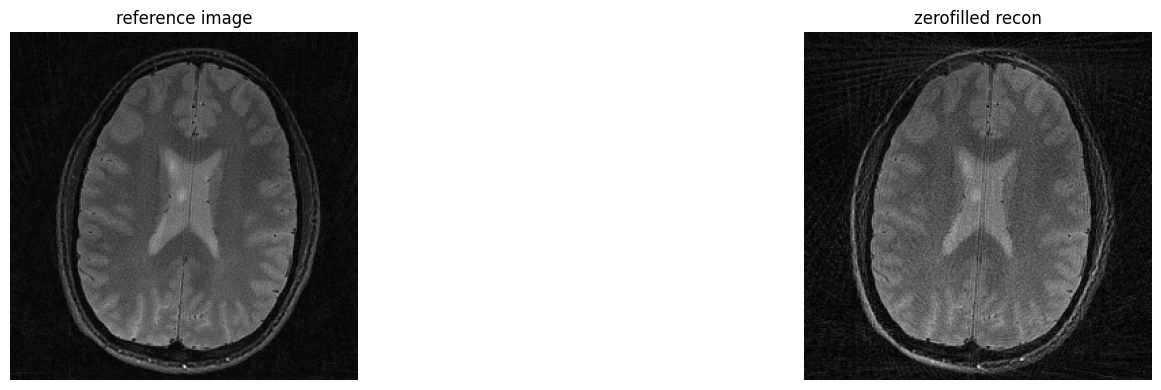

In [2]:
# load raw data
device = "cpu"
data, head, img0 = load_challenge_rawdata(2) # skip every two radial views (acceleration R=2)

# perform simple (zero-filled and CG) recon
img_zf = deepmr.recon.recon_lstsq(data.clone(), copy.deepcopy(head), device=device) 

# plot
plt.rcParams['figure.figsize'] = [20, 4]

plt.subplot(1, 2, 1)
_ = plt.imshow(abs(torch.flip(img0, dims=(-1,)).squeeze().numpy(force=True)).T, cmap="gray"), plt.axis("off"), plt.title("reference image")
plt.subplot(1, 2, 2)
_ = plt.imshow(abs(torch.flip(img_zf, dims=(-1,)).squeeze().numpy(force=True)).T, cmap="gray"), plt.axis("off"), plt.title("zerofilled recon")
plt.tight_layout()

## Iterative Reconstruction
Compared with the reference R=1 acquisition, zero-filled reconstruction exhibits streaking artifacts. We now perform iterative reconstruction using:

1. Tikhonov regularized CG-Sense reconstruction;
2. Soft-thresholded L1-Wavelet regularized Proximal Gradient Method reconstruction;
3. Total Variation regularized Proximal Gradient Method reconstruction.

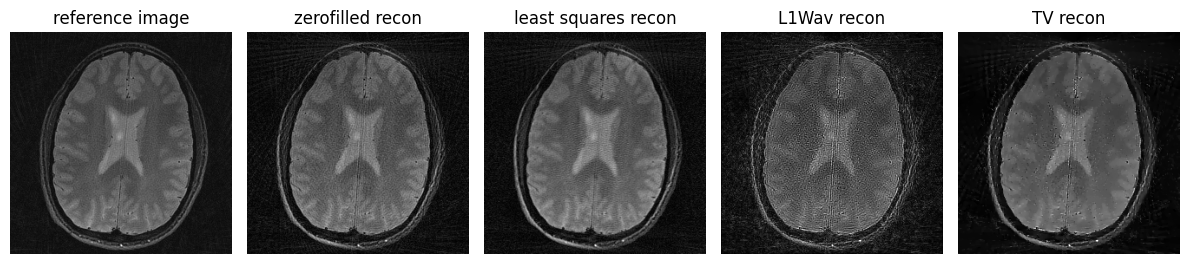

In [3]:
img_tk = deepmr.recon.recon_lstsq(data.clone(), copy.deepcopy(head), niter=10, lamda=0.25, device=device) 
img_l1wav = deepmr.recon.recon_lstsq(data.clone(), copy.deepcopy(head), niter=10, prior="L1Wave", lamda=0.1, stepsize=1.0, device=device) 
img_tv = deepmr.recon.recon_lstsq(data.clone(), copy.deepcopy(head), niter=15, prior="TV", lamda=0.1, stepsize=1.0, device=device) 

plt.rcParams['figure.figsize'] = [12, 4]

plt.subplot(1, 5, 1)
tmp = abs(torch.flip(img0, dims=(-1,)).squeeze().numpy(force=True)).T 
_ = plt.imshow(tmp / tmp.max(), cmap="gray", vmin=0, vmax=1.0), plt.axis("off"), plt.title("reference image")
plt.subplot(1, 5, 2)
tmp = abs(torch.flip(img_zf, dims=(-1,)).squeeze().numpy(force=True)).T 
_ = plt.imshow(tmp / tmp.max(), cmap="gray", vmin=0, vmax=1.0), plt.axis("off"), plt.title("zerofilled recon")
plt.subplot(1, 5, 3)
tmp = abs(torch.flip(img_tk, dims=(-1,)).squeeze().numpy(force=True)).T 
_ = plt.imshow(tmp / tmp.max(), cmap="gray", vmin=0, vmax=1.0), plt.axis("off"), plt.title("least squares recon")
plt.subplot(1, 5, 4)
tmp = abs(torch.flip(img_l1wav, dims=(-1,)).squeeze().numpy(force=True)).T 
_ = plt.imshow(tmp / tmp.max(), cmap="gray", vmin=0, vmax=0.75), plt.axis("off"), plt.title("L1Wav recon")
plt.subplot(1, 5, 5)
tmp = abs(torch.flip(img_tv, dims=(-1,)).squeeze().numpy(force=True)).T 
_ = plt.imshow(tmp / tmp.max(), cmap="gray", vmin=0, vmax=0.7), plt.axis("off"), plt.title("TV recon")
plt.tight_layout()

Different regularization exhibits different artifact reduction, traded-off with different degrees of loss of resolution.
Here, regularization parameters have not been optimized; these can be tuned (either manually or via learning) to preserve the original resolution while minimizing the undersampling artifacts.